# Análise de Negócio
Luiz Guilherme G. R. Pereira

A atividade consiste em judar uma empresa a otimizar suas despesas com marketing. Foi recebido para a análise logs do servidor com dados sobre os acessos a Y.Afisha de janeiro de 2017 até dezembro de 2018, arquivo de despejo com todos os pedidos feitos durante o período e estatísticas de despesas com marketing.

Será anlisado:

- Como as pessoas usam o produto
- Quando elas começam a comprar
- Quanto dinheiro cada cliente traz para a empresa
- Quando as despesas serão cobertas

Será feito relatórios e calculo de métricas:

Produto
- Quantas pessoas usam-no cada dia, semana e mês?
- Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).
- Que comprimento tem cada sessão?
- Com que frequência os usuários voltam?
    
Vendas
- Quando as pessoas começam a comprar?
- Quantos pedidos os clientes fazem durante um determinado período de tempo?
- Qual é o volume médio de uma compra?
- Quanto dinheiro eles trazem para a empresa (LTV)?

Marketing
- Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo
- Quanto custou a aquisição de clientes para cada origem?
- Os investimentos valeram a pena? (ROI)

## PREPARO DOS DADOS

In [1]:
import pandas as pd
import matplotlib as plot
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.float_format = '{:.2f}'.format

A tabela visits (os logs do servidor com dados sobre os acessos ao site):

- Uid — identificador unívoco do usuário
- Device — dispositivo do usuário
- Start Ts — data e hora do início da sessão
- End Ts — data e hora do final da sessão
- Source Id — identificador da origem do anúncio através do qual o usuário chegou

Todas as datas nesta tabela estão no formato YYYY-MM-DD.

In [2]:
try:
    visits = pd.read_csv('visits_log_us.csv', nrows=500)
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv', nrows=500)

In [3]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


In [4]:
visits['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

In [5]:
try:
    visits = pd.read_csv('visits_log_us.csv', dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
) 
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv', dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
) 
    

In [6]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


A tabela orders (dados sobre os pedidos):

- Uid — identificador unívoco do usuário que faz um pedido
- Buy Ts — data e hora do pedido
- Revenue — a receita da Y.Afisha com o pedido

In [7]:
try:
    orders = pd.read_csv('orders_log_us.csv',parse_dates=['Buy Ts']) 
except:
    orders = pd.read_csv('/datasets/orders_log_us.csv',parse_dates=['Buy Ts']) 

In [8]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


A tabela costs (dados sobre as despesas com marketing):

- source_id — identificador da origem de anúncio
- dt — data
- costs — despesas com esta origem de anúncio neste dia

In [9]:
try:
    costs = pd.read_csv('costs_us.csv',
    parse_dates=['dt'],
) 
except:
    costs = pd.read_csv('/datasets/costs_us.csv',
    parse_dates=['dt'],
) 
    

In [10]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Identificação dos Problemas

In [11]:
def see_df(df):
    display(df.head())

In [12]:
see_df(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [13]:
see_df(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [14]:
see_df(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [15]:
visits.columns=visits.columns.str.lower().str.replace(' ', '_')

orders.columns=orders.columns.str.lower().str.replace(' ', '_')

As tabelas foram importadas com seus tipos de dados corrigidos. 

Os nomes das colunas foram corrigidos. 

Não foram encontrados outros problemas.

## Produto

### Quantas pessoas usam-no cada dia, semana e mês?

In [16]:
# criação de datas da sessão
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_date'] = visits['start_ts'].dt.date

In [17]:
# Função para calcular a Quantidade de Usuários Médios
def user_ativ(session):
    total = visits.groupby(session).agg({'uid': 'nunique'}).mean()
    return total

In [18]:
# Quantidade de Usuários Médios por mês, semana e dia
mau_total = user_ativ(['session_year', 'session_month'])
wau_total = user_ativ(['session_year', 'session_week'])
dau_total = user_ativ('session_date')

In [19]:
print(f'Quantidade de Usuários Médios por Mês: ',int(mau_total) )
print('Quantidade de Usuários Médios por Semana: ', int(wau_total))
print('Quantidade de Usuários Médios por Dia: ', int(dau_total))

Quantidade de Usuários Médios por Mês:  23228
Quantidade de Usuários Médios por Semana:  5716
Quantidade de Usuários Médios por Dia:  907


### Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).

In [20]:
# Quantidade de Usuários Médios por mês, semana e dia
def session_ativ(session_date):
    total = visits.groupby(session_date).agg({'uid': 'count'}).mean()
    return total

In [21]:
# Quantidade de Usuários Médios
sessions_per_month = session_ativ(['session_year', 'session_month'])
sessions_per_week = session_ativ(['session_year', 'session_week'])
sessions_per_day = session_ativ('session_date')

In [22]:
print(f'Quantidade Média de Sessões por Mês: ',int(sessions_per_month) )
print(f'Quantidade Média de Sessões por Semana: ',int(sessions_per_week) )
print(f'Quantidade Média de Sessões por Dia: ',int(sessions_per_day) )

Quantidade Média de Sessões por Mês:  29950
Quantidade Média de Sessões por Semana:  6781
Quantidade Média de Sessões por Dia:  987


### Quantas sessões ocorrem por data e usuario?

In [23]:
# Função para calcular a quantidade de usuários e sessões por data
def session_per(session_date):
    sessions_per_user = visits.groupby(session_date).agg({'uid': ['count', 'nunique']})
    sessions_per_user.columns = ['n_sessions', 'n_users']
    sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
    return sessions_per_user

In [24]:
# quantidade de usuários e sessões por mês
quant_month = session_per(['session_year', 'session_month'])
display(quant_month)

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259               1.24
             7                   17828    14183               1.26
             8                   14355    11631               1.23
             9                   23907    18975               1.26
             10                  37903    29692               1.28
             11                  43969    32797               1.34
             12                  41983    31557               1.33
2018         1                   36939    28716               1.29
             2                   37182    28749               1.29
             3                   35679    27473               1.30
             4                   26515    21008               1.26
             5                   26635    20701               1.29

In [25]:
# Media de todas as sessões por usuario po mes
quant_month['sessions_per_user'].mean()

1.2808894945992668

Calculo da Coorte da Retenção por Sessão:

In [26]:
# A data da primeira sessao do usario
visit_first = visits.groupby('uid')['start_ts'].min()
visit_first.name = 'visit_first'
visits = visits.join(visit_first, on='uid')

In [27]:
# Coleta do mes da primeira sessão e da mensal
visits['visit_first_month'] = visits['visit_first'].astype('datetime64[M]')
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')

In [28]:
# Calculo da idade da Coorte
visits['age'] = (visits['start_ts_month'] - visits['visit_first_month']) / np.timedelta64(1, 'M')

visits['age'] = visits['age'].round().astype('int')

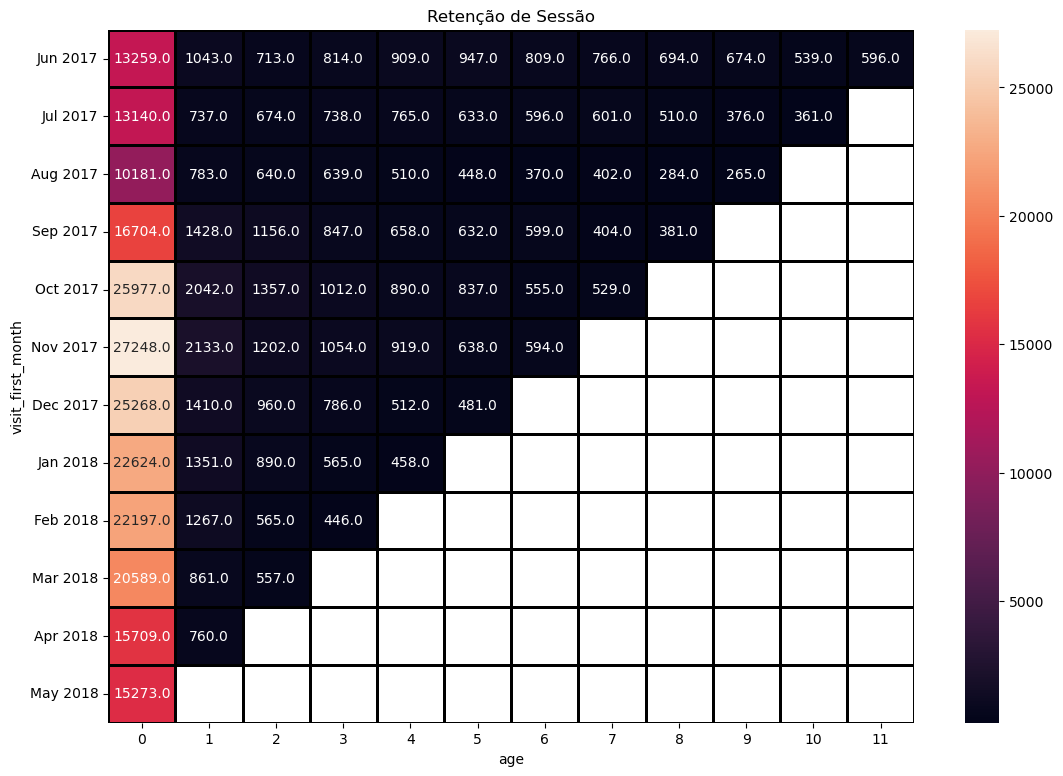

In [29]:
# Criação da Coorte
output1 = visits.pivot_table(index= 'visit_first_month', columns='age', values='uid', aggfunc='nunique')
zero1 =output1[0].copy()

output1.index = output1.index.strftime('%b %Y')

#for col in output1.columns:
#    output1[col] = output1[col]/zero1

# Grafico de Calor
plt.figure(figsize=(13, 9))
plt.title('Retenção de Sessão')
sns.heatmap(output1, annot=True, fmt='.1f', linewidths=1, linecolor='black'); 

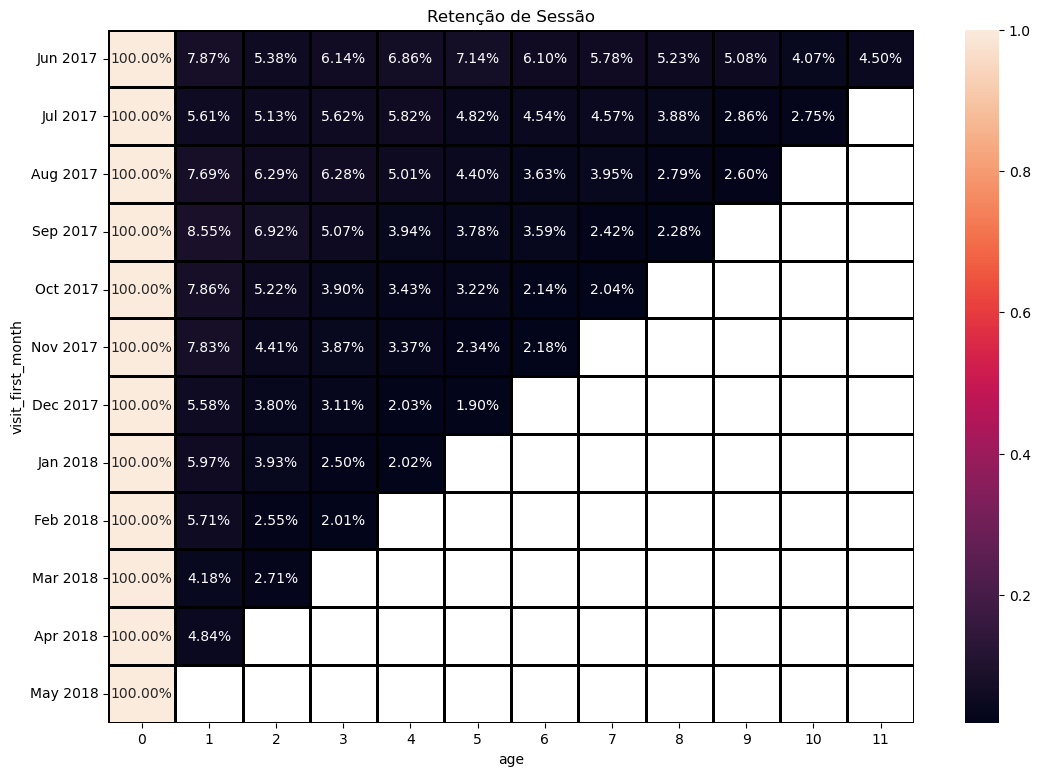

In [30]:
output11 = output1.copy()
zero1 =output1[0].copy()


for col in output11.columns:
    output11[col] = output11[col]/zero1

# Grafico de Calor
plt.figure(figsize=(13, 9))
plt.title('Retenção de Sessão')
sns.heatmap(output11, annot=True, fmt='.2%', linewidths=1, linecolor='black');

Um usuário tem em média um 1.28 sessão por mês. Essas médias mantiveram-se estáveis durante todo o período. 

A coortes mostram que a partir do mês 1, o número de sessões cai para menos de 10% do valor original, então tem um queda gradual, com uma estabilização entre 5% a 3%. As coortes mais recentes tiveram uma queda maior nas sessões do mês 1, isso pode indicar que a retenção piorou. Outro indicio é que a coortes mais novas possuem mais usários no mês zero, mas menos no mês 1, comparado as coortes mais antgas.

### Que comprimento tem cada sessão?

In [31]:
# calculando o tem de sessão médio, mediano e sua moda
lenght_mean = (visits['end_ts'] - visits['start_ts']).dt.seconds.mean()
lenght_median = (visits['end_ts'] - visits['start_ts']).dt.seconds.median()
lenght_mode = (visits['end_ts'] - visits['start_ts']).dt.seconds.mode()

In [32]:
print(f'Tempo Médio de Sessão: {int(lenght_mean)} segundos ou {int(lenght_mean / 60)} minutos')
print()
print(f'Tempo Mediano de Sessão: {int(lenght_median)} segundos ou {int(lenght_median / 60)} minutos')
print()
print(f'Tempo da Moda de Sessão: {int(lenght_mode)} segundos ou {int(lenght_mode / 60)} minutos')

Tempo Médio de Sessão: 643 segundos ou 10 minutos

Tempo Mediano de Sessão: 300 segundos ou 5 minutos

Tempo da Moda de Sessão: 60 segundos ou 1 minutos


Uma sessão normal leva 5 minutos.

### Com que frequência os usuários voltam?

In [33]:
# Calculando porcentagem de retenção mensal e semanal
retetion_mau = (dau_total / mau_total) * 100

retetion_wau = (dau_total / wau_total) * 100

In [34]:
print(f'Retenção Mensal: {retetion_mau.iloc[0]:.2f}%')
print(f'Retenção Semanal: {retetion_wau.iloc[0]:.2f}%')

Retenção Mensal: 3.91%
Retenção Semanal: 15.88%


In [35]:
# A data da primeira sessao do usuario
orders = orders.join(visit_first, on='uid')

In [36]:
# A data da primeira compra do usuario
buy_first = orders.groupby('uid')['buy_ts'].min()
buy_first.name = 'buy_first'
orders = orders.join(buy_first, on='uid')

In [37]:
# coleta do mes e ano da compra
orders['month'] = orders['buy_ts'].dt.month
orders['year'] = orders['buy_ts'].dt.year

In [38]:
# coleta do mes da primeira compra e da compra atual
orders['buy_first_month'] = orders['buy_first'].astype('datetime64[M]')
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')

In [39]:
# idade da coorte
orders['age'] = (orders['buy_ts_month'] - orders['buy_first_month']) / np.timedelta64(1, 'M')

orders['age'] = orders['age'].round().astype('int')

In [40]:
# Tempo de conversão do usuario( Tempo entre a primeira sessao e a primeira compra em dias)
orders['time_conversion'] = (orders['buy_first'] - orders['visit_first']).dt.days

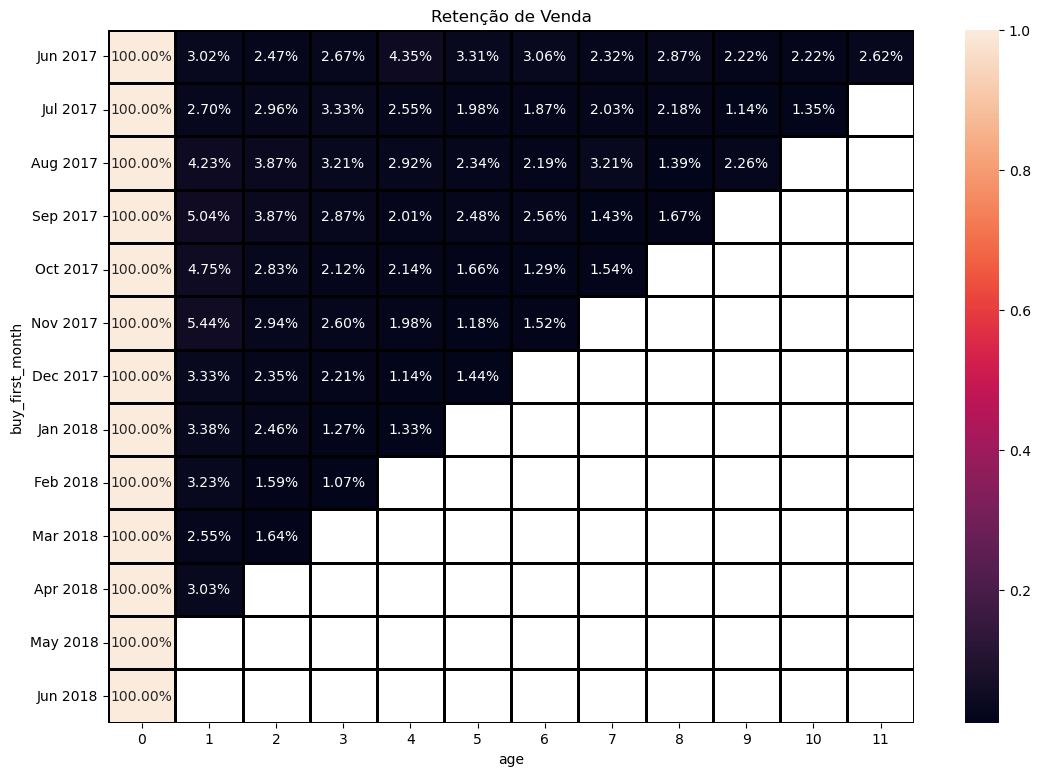

In [41]:
# criacao da coorte de retenção de compra
output2 = orders.pivot_table(index='buy_first_month', columns='age', values='uid', aggfunc='nunique')
zero =output2 [0].copy()


for col in output2.columns:
    output2[col] = output2[col]/zero

output2.index = output2.index.strftime('%b %Y')

# grafico de calor
plt.figure(figsize=(13, 9))
plt.title('Retenção de Venda')
sns.heatmap(output2, annot=True, fmt='.2%', linewidths=1, linecolor='black'); 

Os usuários possuem um nível muito baixo de retenção, apenas 3.91% dos usários em média voltam a comprar no mês seguinte. Sendo 95% dos usuários compram o produto apenas uma vez. 

Pelas coorte podemos ver que após a queda inicial o nível de retenção estabiliza, mas as coortes mais novas tem uma retenção bem menor, os novos usuários não estão voltando para comprar como os novos.

Em relação as sessões, mais usuários nas coortes estão acessando o site do que comprendo, o retenção de compra e aproximadamente metade da retenção de sessão, logo, metade dos usuários que retornam não compram.

## Vendas

### Quando as pessoas começam a comprar? 

In [42]:
# Agregando os tempo de conversão pela quantidade de usuarios unicos
coort_conv = orders.pivot_table(index ='time_conversion', values= 'uid', aggfunc='nunique').reset_index()

# Calculando a porcentagem de usuarios por dia de conversão
coort_conv['%'] = (coort_conv['uid'] / coort_conv['uid'].sum()) * 100

display(coort_conv.head(10))
display(coort_conv.tail())

,time_conversion,uid,%
0,0,26363,72.18
1,1,1011,2.77
2,2,563,1.54
3,3,434,1.19
4,4,324,0.89
5,5,270,0.74
6,6,260,0.71
7,7,218,0.60
8,8,189,0.52
9,9,140,0.38


,time_conversion,uid,%
340,354,1,0.00
341,355,3,0.01
342,357,4,0.01
343,362,1,0.00
344,363,1,0.00


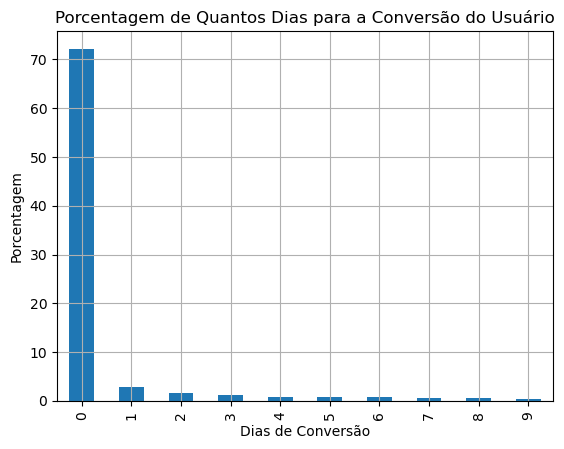

In [43]:
# Gráfico em barras da porcentagem de conversão
coort_conv['%'].head(10).plot(kind='bar', grid=True)
plt.title('Porcentagem de Quantos Dias para a Conversão do Usuário')
plt.xlabel('Dias de Conversão')
plt.ylabel('Porcentagem')
plt.show()

72.18% dos usuários são convertido no mesmo dia. Os outros 27.82% estão distribuidos entre 1 a 344 dias, com cada um desses dias tendo uma porcentagem insiginificante.

### Quantos pedidos os clientes fazem durante um determinado período de tempo?

In [44]:
# Agregando a quantidade de usuarios e de usuarios unicos por mes
buys_per = orders.groupby(['year','month']).agg({'uid': ['count', 'nunique']})
buys_per.columns = ['n_buys', 'n_users']
buys_per['buys_per_user'] = (buys_per['n_buys'] / buys_per['n_users'])
buys_per

n_buys  n_users  buys_per_user
year month                                
2017 6        2354     2023           1.16
     7        2363     1984           1.19
     8        1807     1472           1.23
     9        3387     2750           1.23
     10       5679     4675           1.21
     11       5659     4547           1.24
     12       6218     4942           1.26
2018 1        4721     3898           1.21
     2        5281     4258           1.24
     3        5326     4181           1.27
     4        3273     2744           1.19
     5        4346     3544           1.23
     6           1        1           1.00

In [45]:
buys_per['buys_per_user'].mean()

1.2058233446244648

Os usuários compram em média 1 produto por mês, com alguns poucos usuários comprando mais do que um produto, sendo a média de 1.20 produto por usuário. Tendo um pico de 1.26 em dezembro.

### Qual é o volume médio de uma compra?

In [46]:
# Agrupando a receita, a quantidade de usuarios e usuarios unicos por mes
revenue_per = orders.groupby(['year','month']).agg({'revenue': ['sum'], 'uid':['count','nunique']})
revenue_per.columns = ['revenue', 'buys', 'n_users']

# calculando a receita por venda
revenue_per['revenue_per_buy'] = (revenue_per['revenue'] / revenue_per['buys'])

# calculando a receita por usuario
revenue_per['revenue_per_user'] = (revenue_per['revenue'] / revenue_per['n_users'])

revenue_per

revenue  buys  n_users  revenue_per_buy  revenue_per_user
year month                                                           
2017 6      9557.49  2354     2023             4.06              4.72
     7     12539.47  2363     1984             5.31              6.32
     8      8758.78  1807     1472             4.85              5.95
     9     18345.51  3387     2750             5.42              6.67
     10    27987.70  5679     4675             4.93              5.99
     11    27069.93  5659     4547             4.78              5.95
     12    36388.60  6218     4942             5.85              7.36
2018 1     19417.13  4721     3898             4.11              4.98
     2     25560.54  5281     4258             4.84              6.00
     3     28834.59  5326     4181             5.41              6.90
     4     16858.06  3273     2744             5.15              6.14
     5     20735.98  4346     3544             4.77              5.85
     6         3.42     1        1             3.42              3.42

In [47]:
# media da receita por venda
revenue_per['revenue_per_buy'].mean()

4.838699619166363

In [48]:
# media da receita por usuário
revenue_per['revenue_per_user'].mean()

5.8665136267923845

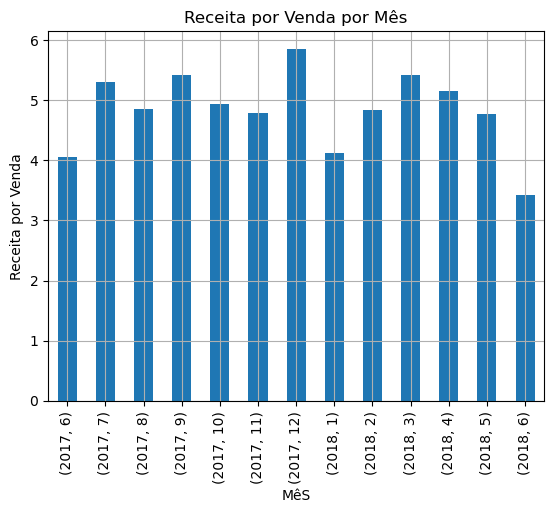

In [49]:
# grafico de barras da media da receita por venda
revenue_per['revenue_per_buy'].plot(kind='bar', grid=True)
plt.title('Receita por Venda por Mês')
plt.xlabel('MêS')
plt.ylabel('Receita por Venda')
plt.show()

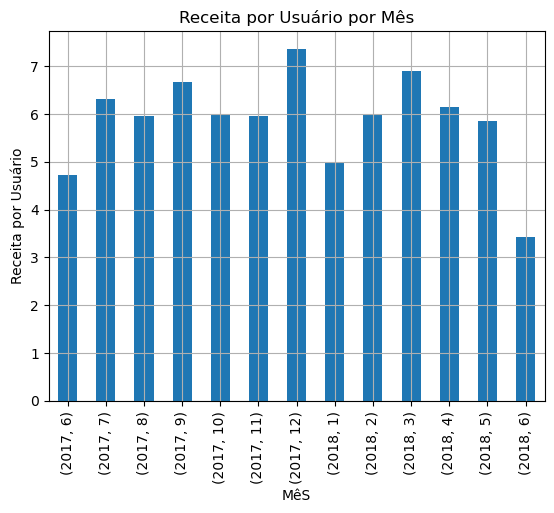

In [50]:
# grafico de barras da media da receita por usuário
revenue_per['revenue_per_user'].plot(kind='bar', grid=True)
plt.title('Receita por Usuário por Mês')
plt.xlabel('MêS')
plt.ylabel('Receita por Usuário')
plt.show()

A receita média por venda é de 4.83 e a receita média por usuário é de 5.86. Ambas as médias são ciclicas, tendo um pico em dezembro seguido por uma queda brusca dos primeiros meses do ano, tendo um segundo pico em março então caindo até junho, quando começa a crescer até dezembro. Em dezembro a venda bate um pico de 5.85 e a por usuário bate um pico de 7.36. 

### Quanto dinheiro eles trazem para a empresa (LTV)?

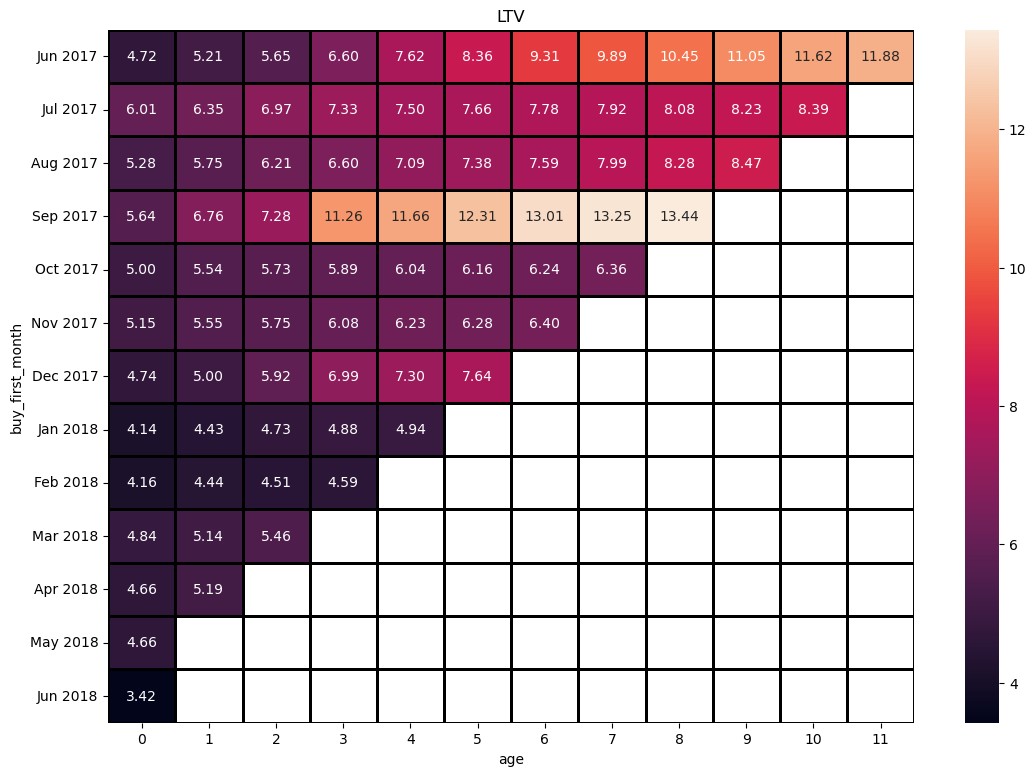

In [51]:
# agrupamento do primeiro mes de compra por quantidade de usuarios
cohort_sizes = orders.groupby('buy_first_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['buy_first_month', 'n_users']

# agrupamento do primeiro mes de compra pela soma da receita
cohorts_revenue = orders.groupby(['buy_first_month','buy_ts_month']).agg({'revenue': 'sum'}).reset_index()

# junção da tabelas
report=pd.merge(cohort_sizes, cohorts_revenue, on='buy_first_month')

# criação da idade da coorte
report['age'] = (report['buy_ts_month'] - report['buy_first_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

# calculo do ltv
report['ltv'] = report['revenue'] / report['n_users']

# criação da coorte
output3 = report.pivot_table(index='buy_first_month', columns='age', values='ltv', aggfunc='mean')

output3.index = output3.index.strftime('%b %Y')

# grafico de calor
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output3.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black');

As coortes de LTV( life time value) do site apresenta uma priora, com as coortes mais novas tendo um LTV muito mais baixo do que as mais antigas. 

A coorte de setembro de 2017 foi destacou-se tendo um LTV muito no mês 2 muito maior do que as outras coortes. Seria interessante investigar essa coorte, para averiguar se houve umapromoção feita.

O crescimento do LTV das coorte é pequeno, mas com há uma retenção de compra de 3%, significa que os usuários que retornam compram em grande quantidade quantidade .

O LTV das idades tem piorado, com as coortes mais antigas possuindo um LTV de aproximadamente 5 no mês 0, as coortes mais novas possuem um LTV de aproximadamente 4.

## Marketing

### Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo

In [52]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs['dt_week'] = costs['dt'].astype('datetime64[W]')

In [53]:
print(f'Custos totais em Marketing: ',costs['costs'].sum() )


Custos totais em Marketing:  329131.62


In [54]:
# porcentagem dos gastos
display(costs.groupby('source_id')['costs'].sum() / costs['costs'].sum())

source_id
1    0.06
2    0.13
3    0.43
4    0.19
5    0.16
9    0.02
10   0.02
Name: costs, dtype: float64

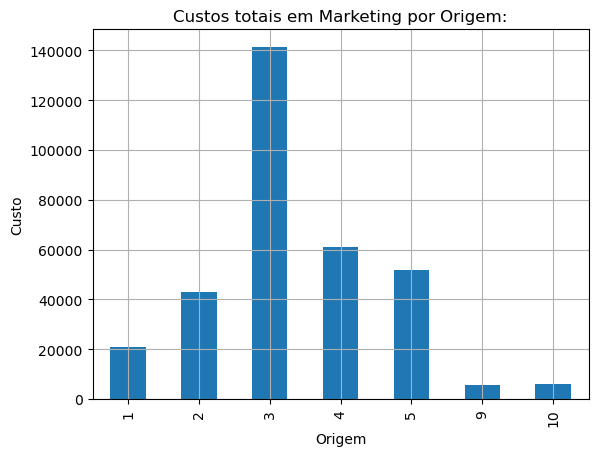

In [55]:
costs_orig = costs.groupby('source_id')['costs'].sum()

costs_orig.plot(kind='bar', grid=True)
plt.title('Custos totais em Marketing por Origem:')
plt.xlabel('Origem')
plt.ylabel('Custo')
plt.show()

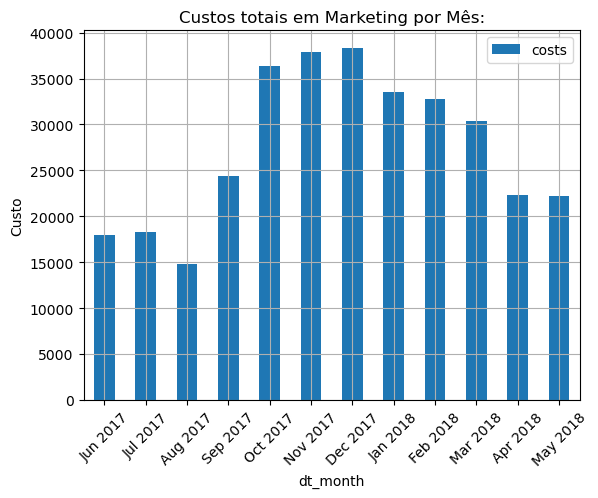

In [56]:
costs_month = costs.pivot_table(index='dt_month',values='costs',aggfunc='sum')

costs_month.plot(kind='bar', grid=True)
plt.title('Custos totais em Marketing por Mês:')

plt.xticks(range(len(costs_month.index)), costs_month.index.strftime('%b %Y'), rotation=45)
plt.ylabel('Custo')
plt.show()

O gasto total com marketing foi de 329 mil. Os maiores custos foram de origem 3, custou 140 mil, representando 43% do gasto total em marketing. As fontes de publicidade 4 e 5 representaram 19% e 16%, sendo os segundo e terceiro maiores.

Os gatos mensais em marketing foram mais altos entre setembro de 2017 e março de de 2018. Os gastos mensais não possuem semalhança com a receita média por venda ou por usuário, sendo assim, deve-se questionar a capacidade do marketing, mas aos meses com menores gastos tambem tiveram as menores receitas. Sendo assim, é necessario aprofundar no assunto. 

### Quanto custou a aquisição de clientes para cada origem?

In [57]:
orders_visits= pd.merge(orders,visits, on='uid')
revenue_sum = orders_visits.pivot_table(index='source_id', values='revenue', aggfunc='sum').reset_index()

In [58]:
uid_count = visits.pivot_table(index='source_id', values='uid', aggfunc='nunique').reset_index()
costs_sum = costs.pivot_table(index='source_id', values='costs', aggfunc='sum').reset_index()

cost_cac = pd.merge(uid_count, costs_sum, on='source_id')
cost_cac = pd.merge(cost_cac, revenue_sum, on='source_id')

cost_cac['return_by_user'] = cost_cac['revenue'] / cost_cac['uid']
cost_cac['cac'] = cost_cac['costs'] / cost_cac['uid']

cost_cac['revenue_cac'] = cost_cac['return_by_user'] / cost_cac['cac']
cost_cac

,source_id,uid,costs,revenue,return_by_user,cac,revenue_cac
0,1,18999,20833.27,2298200.17,120.96,1.10,110.31
1,2,26245,42806.04,2638189.21,100.52,1.63,61.63
2,3,74756,141321.63,296687.96,3.97,1.89,2.10
3,4,83525,61073.60,496690.17,5.95,0.73,8.13
4,5,56974,51757.10,1181477.14,20.74,0.91,22.83
5,9,9264,5517.49,36342.25,3.92,0.60,6.59
6,10,8067,5822.49,14619.23,1.81,0.72,2.51


Os CAC mais caros são da origem 3, 2 e 1. Mas em relação ao retorno que trazem a origem possue uma relação de 110 de retono por CAC, o maior das origens, e da origem 2 de 61 vezes, o segundo maior. A relação da origem 3 é de 2 vezes, a menor entre todas as origens.

Em relação a receita absoluta as receitas 2, 1 e 5 trazem as maiores receitas, com 2.6 milhões, 2.2 milhões e 1.18 milhões, respectivamente. A origem 3 traz apenas 296 mil.

Em relação ao número de  de usuários as origens 4, 3 e 5 trazem as maiores quantidade de usuários, com 83 mil, 74 mil e 56 mil, respectivamente.

Aconselho  parar de gastar dinheiro na origem 3, por ter o maior custo total, a menor receita total, o maior CAC e o pior retorno por CAC. As melhores origens para investir são a origem 1 e 2, que possuem o maior retorno por CAC e maiores receitas totais e  a origem 5 por possuir um CAC menor e possuir o maior número de usuários já atraídos, e um retorno por CAC interessante.

### Os investimentos valeram a pena? (ROI)

In [59]:

report= pd.merge(report,costs_month, left_on='buy_ts_month', right_on='dt_month')
report['cac'] = report['costs'] / report['n_users']
report['romi'] = report['ltv'] / report['cac']

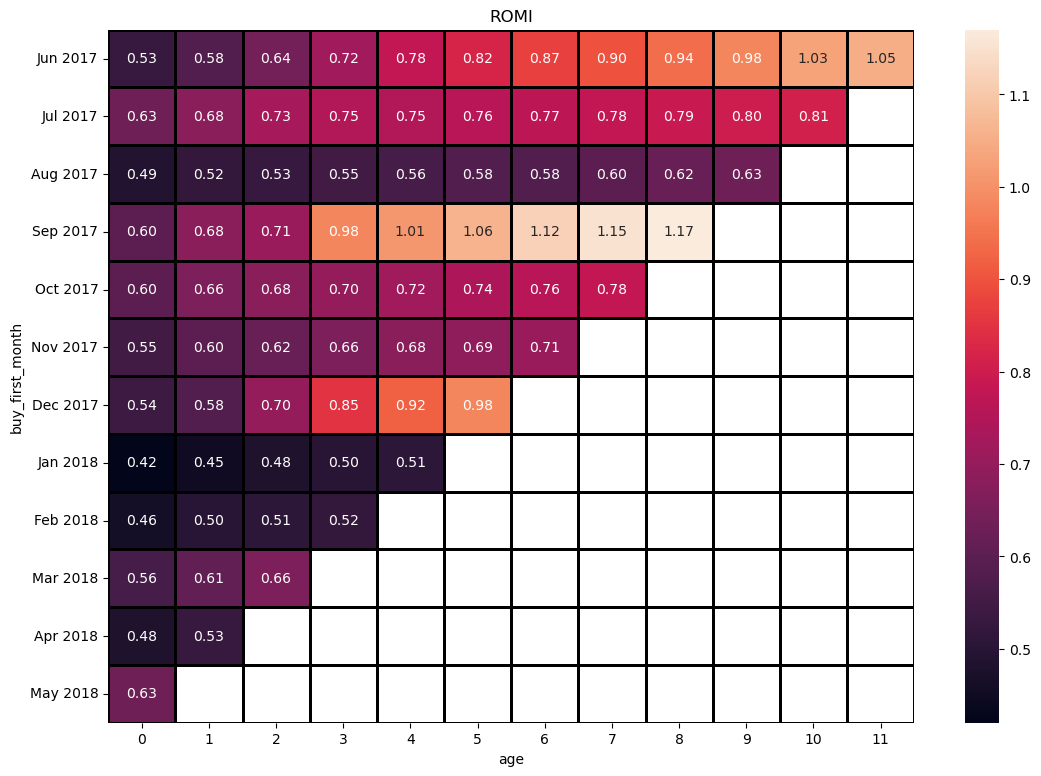

In [60]:
output4 = report.pivot_table(index='buy_first_month', columns='age', values='romi', aggfunc='mean')

output4.index = output4.index.strftime('%b %Y')

#output2.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output4.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black');

Em relação ao retorno sobre o investimento, parece haver um ciclo com uma coorte com um bom retorno seguida de duas com um retorno ruim. A coorte do mês de setembro de 2017, teve um ótimo retorno, paguando-se na idade 4. As coortes boas precisam de uma idade 10 para pagarem-se, enquanto as coorte ruins precisam de mais, o quanto não se sabe ou se darão prejuízo.

O mês zero de vida paga metade do investimento das coortes, depois aumenta gradualmente, a velocidade depende da qualidade da coorte.

## Conclusão

Em conclusão, a retenção de usuários é baixa, com apenas 3.91% dos usuários retornando para comprar no mês seguinte. Isso indica que há uma oportunidade de melhoria na retenção e fidelização dos clientes. A retenção de vendas é metade da retenção de sessões. Portanto, é necessário analisar e otimizar a jornada do usuário para melhorar a taxa de conversão de vendas. Deve-se investigar por que metade dos usuários não está finalizando a compra.

A receita média por venda e por usuário apresenta variações sazonais, com picos em dezembro. As coortes mais antigas possuem um LTV maior do que as coortes mais recentes, indicando que a qualidade dos usuários adquiridos recentemente é inferior em termos de geração de receita ao longo do tempo. É essencial encontrar maneiras de aumentar o LTV das coortes mais recentes. Uma das formas é aumentar a retenção para que o LTV aumente mais rapidamente.

A origem 3 é a que possui o maior custo total de marketing, menor retorno por CAC e menor receita total. Recomenda-se interromper os gastos com essa origem. As melhores origens para investir são a origem 1 e 2, devido ao seu alto retorno por CAC e maiores receitas totais. A origem 5 também é interessante devido ao seu menor CAC e ao maior número de usuários atraídos. A mudança nos gastos de marketing deve aumentar o LTV, pois os usuários das origens 1 e 2 gastam mais.

Observa-se um ciclo de coortes com bom retorno alternado com coortes de retorno ruim. A coorte de setembro de 2017 obteve um ótimo retorno, enquanto as coortes subsequentes tiveram retornos menos satisfatórios. É importante procurar melhorar a retenção e identificar por que há diferenças na qualidade da coorte, a fim de diminuir o tempo necessário para obter um retorno sobre o investimento.

Sendo assim, recomenda-se focar os gastos nas origens 1, 2 e 5 para investimentos futuros e cortar os gastos com marketing nos primeiros meses do ano, pois não estão resultando em aumento na receita por venda. É recomendado alocar esses recursos para os últimos meses do ano, que possuem a maior receita por venda e por usuário.

Além disso, deve-se investigar o mês de setembro de 2017, que teve um LTV e ROMI anormalmente alto, para identificar a causa e replicação. É importante concentrar-se na melhoria da retenção de usuários, aumentar a taxa de conversão e buscar estratégias para aumentar o LTV das coortes mais recentes.